In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from scipy import stats
import torch.nn as nn
from sklearn.metrics import r2_score

from func2graph import data, models, tools, baselines

In [3]:
KK_GT = np.load('../../data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')
max_abs = np.max(np.abs(KK_GT))
vmin_KK = -max_abs
vmax_KK = max_abs

In [4]:
input_mouse = ['SB025']
input_sessions = [['2019-10-23']]


window_size = 60  ################
batch_size = 32
normalization = "session"

train_dataloader, val_dataloader, num_unqiue_neurons, cell_type_order, all_sessions_new_cell_type_id, num_batch_per_session_TRAIN, num_batch_per_session_VAL, sessions_2_original_cell_type, neuron_id_2_cell_type_id = data.generate_mouse_all_sessions_data(
    input_mouse=input_mouse,
    input_sessions=input_sessions,
    window_size=window_size,
    batch_size=batch_size,
    normalization=normalization,
)

checkpoint_path = "../../output/Baselines/AwC_M_60_22.ckpt"   ################
trained_model = models.Attention_With_Constraint.load_from_checkpoint(checkpoint_path)
trained_model.eval()

trainer = pl.Trainer(
    devices=[0],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)

val_results = trainer.predict(trained_model, dataloaders=[val_dataloader])

predictions = []
ground_truths = []
all_R_squared = []

index = 0
num_session = len(num_batch_per_session_VAL)
for i in range(num_session):
    predictions.append([])
    ground_truths.append([])

    for j in range(num_batch_per_session_VAL[i]):
        x_hat = val_results[index][0]
        x = val_results[index][1]
        
        predictions[i].append(x_hat)
        ground_truths[i].append(x)
        index += 1
    
    predictions[i] = torch.cat(predictions[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    ground_truths[i] = torch.cat(ground_truths[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    print(predictions[i].shape, ground_truths[i].shape)
    R_squared = r2_score(ground_truths[i].reshape(ground_truths[i].shape[0], -1), predictions[i].reshape(predictions[i].shape[0], -1), multioutput='variance_weighted')
    all_R_squared.append(R_squared)

print('all_R_squared:', np.mean(all_R_squared))

print('flattened R^2', r2_score(ground_truths[0].reshape(-1), predictions[0].reshape(-1)))

mse = np.mean((predictions[0] - ground_truths[0]) ** 2)
print('mse:', mse)

SB025/2019-10-23
no normalization
cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /homes/gws/wz86/func2graph/notebook/check_evaluation/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 22/22 [00:00<00:00, 44.81it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  338            	|  3.1021         	

(704, 527, 1) (704, 527, 1)
all_R_squared: -0.10402174374113737
flattened R^2 0.49515911253222533
mse: 0.45224577


In [7]:
train_results = trainer.predict(trained_model, dataloaders=[train_dataloader])

predictions_TRAIN = []
ground_truths_TRAIN = []

index = 0
num_session = len(num_batch_per_session_TRAIN)
for i in range(num_session):
    predictions_TRAIN.append([])
    ground_truths_TRAIN.append([])

    for j in range(num_batch_per_session_TRAIN[i]):
        x_hat = train_results[index][0]
        x = train_results[index][1]
        
        predictions_TRAIN[i].append(x_hat)
        ground_truths_TRAIN[i].append(x)
        index += 1
    
    predictions_TRAIN[i] = torch.cat(predictions_TRAIN[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    ground_truths_TRAIN[i] = torch.cat(ground_truths_TRAIN[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    print(predictions_TRAIN[i].shape, ground_truths_TRAIN[i].shape)

    T, N, W = predictions_TRAIN[i].shape

    # train_mean: N * 1
    train_mean = np.mean(ground_truths_TRAIN[i].reshape(-1, N), axis=0)
    flattened_train_mean = np.mean(ground_truths_TRAIN[i])
    print('train_mean:', train_mean.shape)

    # for validation
    R_squared = tools.R_squared_w_trainMean(ground_truths[i].reshape(-1, N), predictions[i].reshape(-1, N), train_mean)
    print('R_squared:', R_squared)

    flattened_R_squared = tools.flattened_R_squared_w_trainMean(ground_truths[i].reshape(-1), predictions[i].reshape(-1), flattened_train_mean)
    print('flattened_R_squared:', flattened_R_squared)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 96/96 [00:01<00:00, 51.53it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  4460           	|  7442.6         	

(3072, 527, 1) (3072, 527, 1)
train_mean: (527,)
R_squared: [-6.575286865234375, -1.8508262634277344, -0.18034493923187256, -2.715803384780884, -0.6750152111053467, 0.14779990911483765, 0.4777052402496338, -0.077597975730896, -0.03452479839324951, -0.7904009819030762, 0.0469323992729187, 0.09061330556869507, -0.18628168106079102, -0.7652307748794556, -0.21402490139007568, -0.06341004371643066, 0.1485968828201294, -0.05200362205505371, 0.08254599571228027, -0.01537775993347168, -0.2140744924545288, 0.016215026378631592, 0.06704336404800415, 0.10823953151702881, 0.14004260301589966, -0.8449857234954834, 0.11457616090774536, -0.17717254161834717, -0.04119610786437988, 0.021324753761291504, 0.005132496356964111, -0.1543440818786621, -0.47974693775177, -0.03956937789916992, -0.06827092170715332, 0.32245075702667236, -0.8261680603027344, -0.19151699542999268, -0.2912181615829468, 0.28627312183380127, -0.007366061210632324, 0.10157632827758789, -0.21501994132995605, 0.25040024518966675, -0.17

### Attention

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 96/96 [00:01<00:00, 51.98it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  1712           	|  187.0          	

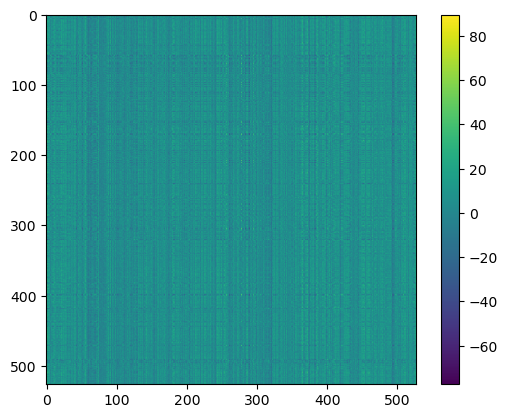

In [5]:
train_results = trainer.predict(trained_model, dataloaders=[train_dataloader])

attentions = []
all_sessions_avg_attention_NN = []

index = 0
num_session = len(num_batch_per_session_TRAIN)
for i in range(num_session):
    attentions.append([])

    for j in range(num_batch_per_session_TRAIN[i]):
        x_hat = train_results[index][0]
        x = train_results[index][1]
        attention = train_results[index][2]

        attentions[i].append(attention)
        
        index += 1

    attentions[i] = torch.cat(attentions[i], dim=0).cpu().numpy()    # N * neuron_num * neuron_num
    # get average attention across samples in each session
    all_sessions_avg_attention_NN.append(np.mean(attentions[i], axis=0))   # neuron_num * neuron_num

plt.imshow(all_sessions_avg_attention_NN[0])
plt.colorbar()
plt.show()

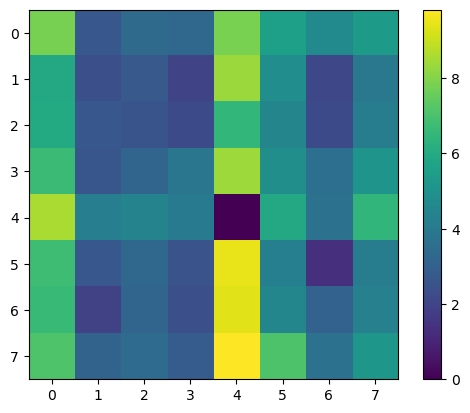

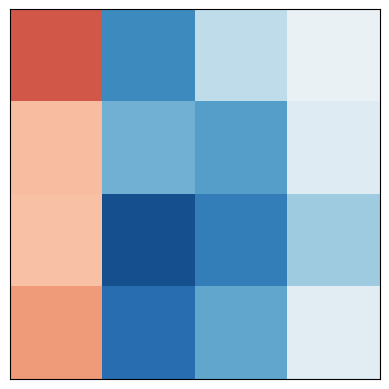

In [11]:
experiment_KK_strength = tools.multisession_NN_to_KK_1(
    all_sessions_avg_attention_NN, 
    None,
    cell_type_order,
    all_sessions_new_cell_type_id,
)

plt.imshow(experiment_KK_strength)
plt.colorbar()
plt.show()

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_strength = tools.experiment_KK_to_eval_KK(experiment_KK_strength, cell_type_order, eval_cell_type_order)

transformed_eval_KK_strength = tools.linear_transform(eval_KK_strength, KK_GT)
plt.imshow(transformed_eval_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()

### Next Time-step Activity Prediction Performance on Real Data

Correlation:  PearsonRResult(statistic=0.7039766866450128, pvalue=0.0)
R squared:  0.4951591125322253


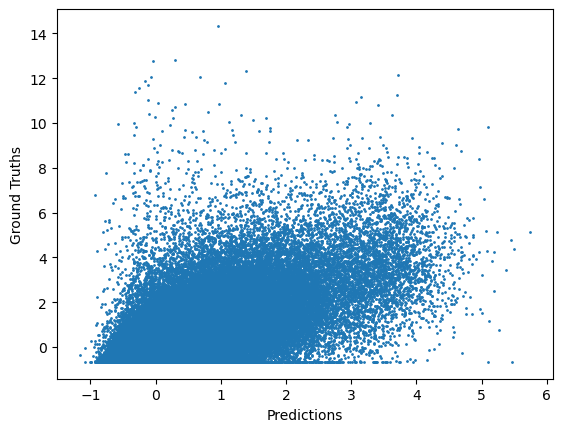

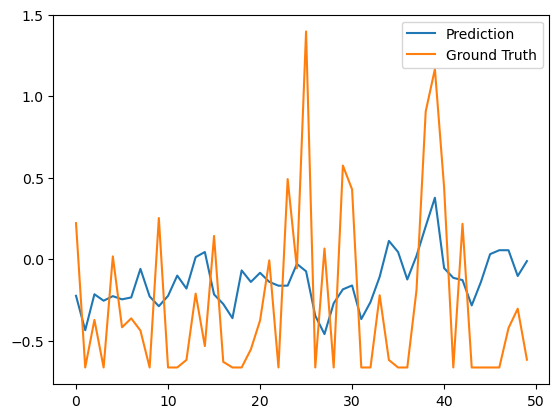

In [28]:
flatten_predictions = [predictions[0].flatten()]
flatten_ground_truths = [ground_truths[0].flatten()]

for i in range(1, num_session):
    flatten_predictions.append(predictions[i].flatten())
    flatten_ground_truths.append(ground_truths[i].flatten())

flatten_predictions = np.concatenate(flatten_predictions)
flatten_ground_truths = np.concatenate(flatten_ground_truths)

corr = stats.pearsonr(flatten_predictions, flatten_ground_truths)
R_squared = r2_score(flatten_ground_truths, flatten_predictions, multioutput='variance_weighted')

print("Correlation: ", corr)
print("R squared: ", R_squared)

plt.scatter(flatten_predictions, flatten_ground_truths, s=1)
plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.show()

one_neuron_pred = predictions[0][:, 5, :]
one_neuron_gt = ground_truths[0][:, 5, :]

plt.plot(one_neuron_pred.flatten()[:50], label="Prediction")
plt.plot(one_neuron_gt.flatten()[:50], label="Ground Truth")
plt.legend()
plt.show()

(2481, 2481)


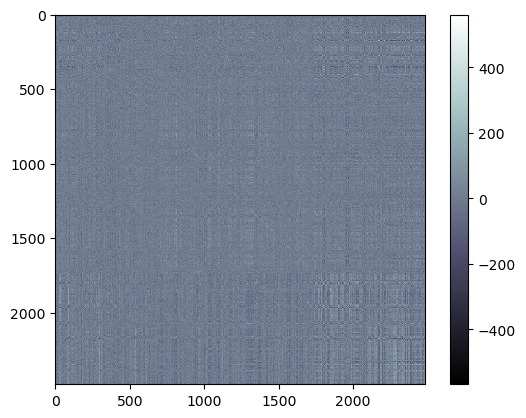

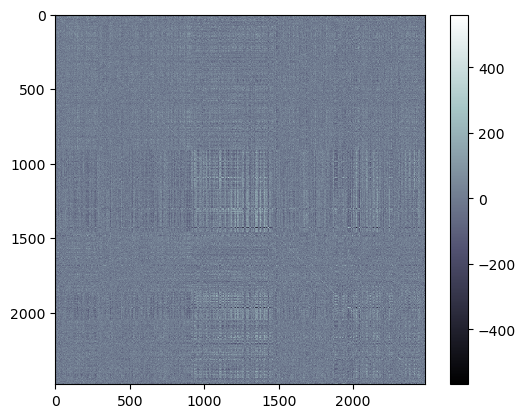

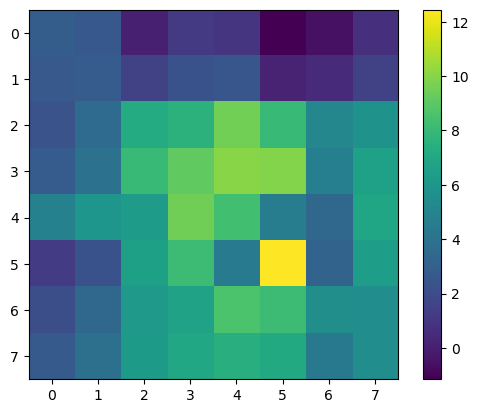

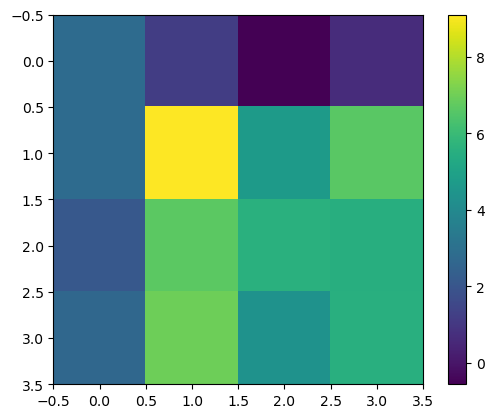

In [4]:
indices = torch.arange(num_unqiue_neurons)
neuron_embeddings = trained_model.embedding_table(indices).cpu().detach().numpy()

W_Q_W_KT = trained_model.attentionlayers[0][0].W_Q_W_KT.weight.cpu().detach().numpy()  # (out_dim, in_dim)
W_Q_W_KT = W_Q_W_KT.T  # (in_dim, out_dim)

result = neuron_embeddings @ W_Q_W_KT @ neuron_embeddings.T
print(result.shape)

plt.imshow(result, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.show()

result = tools.group_connectivity_matrix_by_cell_type(result, neuron_id_2_cell_type_id)

plt.imshow(result, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.show()

KK_result = tools.multisession_NN_to_KK_1(
    [result], 
    multisession_binary_NN_list=None, 
    cell_type_order=cell_type_order, 
    multisession_cell_type_id_list=[neuron_id_2_cell_type_id]
)

plt.imshow(KK_result, interpolation='nearest')
plt.colorbar()
plt.show()

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_result = tools.experiment_KK_to_eval_KK(KK_result, cell_type_order, eval_cell_type_order)

plt.imshow(eval_KK_result, interpolation='nearest')
plt.colorbar()
plt.show()

In [5]:
# loop through trainloader
results= []

for i, batch in enumerate(train_dataloader):
    x, neuron_ids, cell_type_ids = batch         # x is entire window
    x = x.squeeze(0)                 # remove the fake batch_size
    neuron_ids = neuron_ids.squeeze(0)
    cell_type_ids = cell_type_ids.squeeze(0)

    neuron_embeddings = trained_model.embedding_table(neuron_ids[0]).cpu().detach().numpy()
    result = neuron_embeddings @ W_Q_W_KT @ neuron_embeddings.T
    results.append(result)

713
6
(460, 460)
(178, 178)
(522, 522)
(497, 497)
(527, 527)
(495, 495)


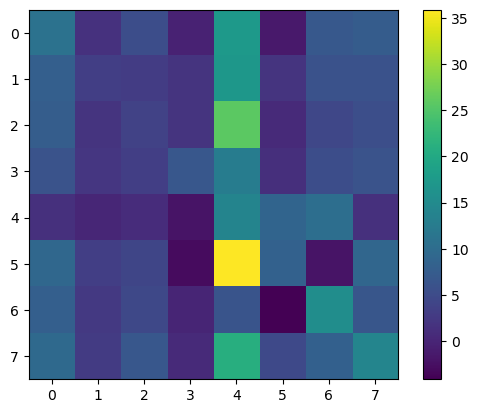

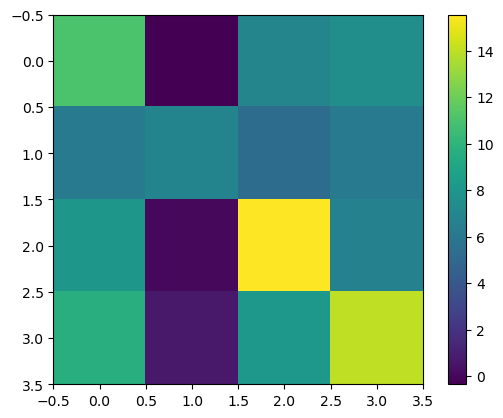

In [7]:
print(len(results))   # total number of batches for all sessions

all_session_results = []
accum = 0
for num in num_batch_per_session_TRAIN:
    all_session_results.append(results[accum])
    accum += num

print(len(all_session_results))
for i in range(len(all_session_results)):
    print(all_session_results[i].shape)


KK_result = tools.multisession_NN_to_KK_1(
    all_session_results, 
    multisession_binary_NN_list=None, 
    cell_type_order=cell_type_order, 
    multisession_cell_type_id_list=all_sessions_new_cell_type_id
)

plt.imshow(KK_result, interpolation='nearest')
plt.colorbar()
plt.show()

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_result = tools.experiment_KK_to_eval_KK(KK_result, cell_type_order, eval_cell_type_order)

plt.imshow(eval_KK_result, interpolation='nearest')
plt.colorbar()
plt.show()

### Attention across samples (time)

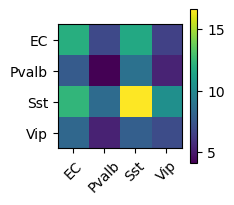

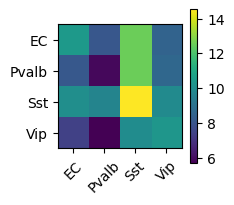

In [4]:
def plot_KK_at_sample(session_num, sample_num):
    KK = tools.multisession_NN_to_KK_1(
        [attentions[session_num][sample_num]], 
        None,
        cell_type_order,
        [all_sessions_new_cell_type_id[session_num]],
    )

    eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
    eval_KK = tools.experiment_KK_to_eval_KK(KK, cell_type_order, eval_cell_type_order)

    plt.figure(figsize=(2,2))
    plt.imshow(eval_KK)
    plt.xticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
    plt.yticks(np.arange(len(eval_cell_type_order)), eval_cell_type_order)
    plt.colorbar()
    plt.show()

plot_KK_at_sample(0, 0)
plot_KK_at_sample(0, 2000)

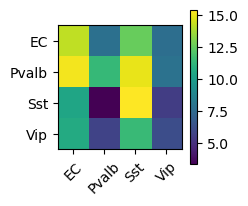

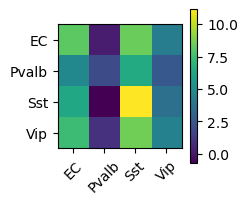

In [5]:
plot_KK_at_sample(2, 0)
plot_KK_at_sample(2, 2000)

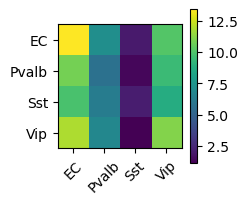

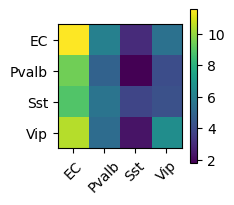

In [6]:
plot_KK_at_sample(4, 0)
plot_KK_at_sample(4, 2000)

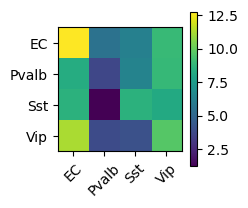

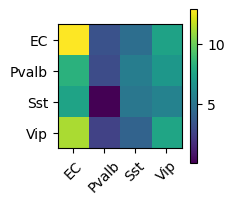

In [7]:
plot_KK_at_sample(5, 0)
plot_KK_at_sample(5, 2000)

In [5]:
session_num=5
attentions_for_session = attentions[session_num]
print(attentions_for_session.shape)
num_sample = len(attentions_for_session)
eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']

matrices = []

for sample_num in tqdm(range(100)):
    sample = attentions_for_session[sample_num]

    KK = tools.multisession_NN_to_KK_1(
            [sample], 
            None,
            cell_type_order,
            [all_sessions_new_cell_type_id[session_num]],
        )
    eval_KK = tools.experiment_KK_to_eval_KK(KK, cell_type_order, eval_cell_type_order)
    # Normalization ##########################################################################################
    eval_KK = (eval_KK - np.mean(eval_KK)) / np.std(eval_KK)
    matrices.append(eval_KK)

min_val = np.min(matrices)
max_val = np.max(matrices)
print(min_val, max_val)

(3968, 495, 495)


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]

-2.277261413909921 2.4409020129447665
